In [3]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)


from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
    KFold,
    cross_validate
)

from tqdm import tqdm 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline

from sklearn.ensemble import ExtraTreesClassifier

import sys
sys.path.insert(0, '../')
from utils import multivariate_classifier, correct_name_markers, plot_univariate

Using MNE with API > 0.19


In [4]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette
(nt_colors))

# Load Data
Loads data from the computed markers. From `Data` directory

In [5]:
data_path = "../../Data/"
results_path = "../../Results/"
fig_path = "../../Results/Figs/"

df = pd.read_csv(os.path.join(data_path, 'all_markers.csv'), index_col = 0)

In [6]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se','msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b',]

erps =['CNV', 'P1', 'P3a', 'P3b']

df_markers = (df
              .query("stimuli == 'go'") # only go trials
              .query("correct == 'correct'") #only correct trials
              .query('prev_trial < 5') # only last 5 trials before each probe. 
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type', 'preproc', 'ft', 'ft_n'], axis = 1) # drop unnecessary columns
              .query("mind in ['on-task','dMW', 'sMW']") # only mind wandering and on-task trials
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1) # drop participants with less than 2 trials per segment
             )

# By segment Mulivariate analysis

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.


Prepares the dataframe for the analysis

In [7]:
variance = lambda x: np.std(x)/np.mean(x)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers.query("probe == 'PC'")
    .groupby(["segment", "participant"], as_index=False)
    .agg(agg_dict)
    #     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(mind2=lambda df: np.where(df.mind == "on-task", "on-task", "mw"))
)

#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_mind = correct_name_markers(df_mind) #correct names for latex

df_mind.columns = df_mind.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_mind  = (df_mind
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment', 'mind2$_{}$':'mind2'})
#             .query("mind != 'dMW'") #if you want to test against just one of the mw            
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )


In [8]:
def multivariate_classifier(
    data, label, features, model ,pca = False, n_components = 3,  cv_splits = 5,grid_search=False,plot = True, permutation=False, n_permutations = 1000 
):
    """
    data: dataframe with features and labels
    label: name of the column with the labels for the classification
    features: feaure or list of features corresponding to the columns of the data frame with the markers
    model: type of classifier model {SVM or forest}
    pca: if use pca as reduction
    n_components: number of components of the pca
    cv_splits: number of crossvalidations splits
    grid_search: if true it will apply grid search 5cv to find the best parameters of C and gamma, only for the SVM. Deafault: False
    n_permutations: number of permutations
    """
    #pipeline steps init
    steps = [("scaler", StandardScaler())]
    
    if pca == True:
        steps.append(('pca', PCA(n_components = n_components)))
        
    C= 0.001
    gamma=0.1
    
    y, lbl = pd.factorize(data[label])
    X = data[features].astype("float32").values
        
    if grid_search == True:
 

        steps_grid = steps.copy()
        steps_grid.append(("SVM", SVC(probability=True)))
        pipe_grid = Pipeline(steps_grid)

        parameteres = {
            "SVM__C": [0.001, 0.1, 10, 100, 10e5],
            "SVM__gamma": [1,0.5, 0.1, 0.01, 0.001],
        }
        
        grid = GridSearchCV(pipe_grid, param_grid=parameteres, cv=cv_splits, n_jobs=-1)
        grid.fit(X, y)
        
        print(grid.best_params_)
        
        C=grid.best_params_["SVM__C"]
        gamma=grid.best_params_["SVM__gamma"]
        
    if model == 'SVM':
        steps.append(('SVM', SVC(C = C, gamma = gamma, probability = True)))       

        pipe_cv = Pipeline(steps)

        cv = KFold(cv_splits, shuffle=True, random_state = 42)

        aucs = cross_val_score(
            X=X,
            y=y,
            estimator=pipe_cv,
            scoring="roc_auc",
            cv=cv,
        )

  
    if model == 'forest':
        n_estimators = 1000
        steps.append(('Forest',ExtraTreesClassifier(
                n_estimators=n_estimators, max_features=1, criterion='entropy',
                max_depth=None, random_state=42, class_weight=None)))
        
        pipe_cv = Pipeline(steps)
        
        cv = KFold(cv_splits, shuffle=True, random_state = 42)


        output = cross_validate(
            X=X, y=y, estimator=pipe_cv,
            scoring='roc_auc', cv=cv,  n_jobs = -1, return_estimator =True)

        aucs = output['test_score']

        feature_importances = pd.DataFrame(features, columns = ['features'])
        for idx,estimator in enumerate(output['estimator']):
            feature_importances[idx] = estimator.named_steps['Forest'].feature_importances_ 

        feature_importances['mean_importance'] = feature_importances.iloc[:, [1,2,3,4,5]].mean(axis=1)
            
        
        df_auc = pd.DataFrame(aucs, columns=["auc"])
    
    
    if plot == True:
        sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
        plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
        plt.axvline(x = 0.5, linestyle = 'dashed')
        plt.show()
        
     
    if permutation == True:
        score, perm_scores, pvalue = permutation_test_score(
            pipe_cv, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
        )
            

        print(f"p_value = {pvalue}")
        
        plt.hist(perm_scores, bins=20, density=True)
        plt.axvline(score, ls="--", color="r")
        score_label = (
            f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
        )
        plt.text(score, np.max(perm_scores), score_label, fontsize=12)
        plt.xlabel("Accuracy score")
        plt.ylabel("Probability")
        plt.show()
        
    if model == 'forest':
        if permutation == True:
            return df_auc, feature_importances, perm_scores, pvalue
        
        else:
            return df_auc, feature_importances
    
    else:
        return df_auc, 

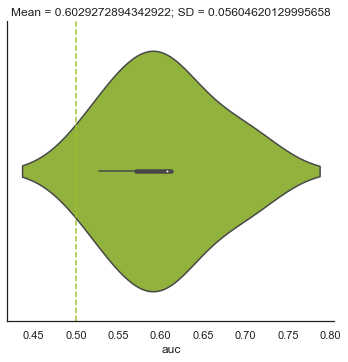

p_value = 0.03796203796203796


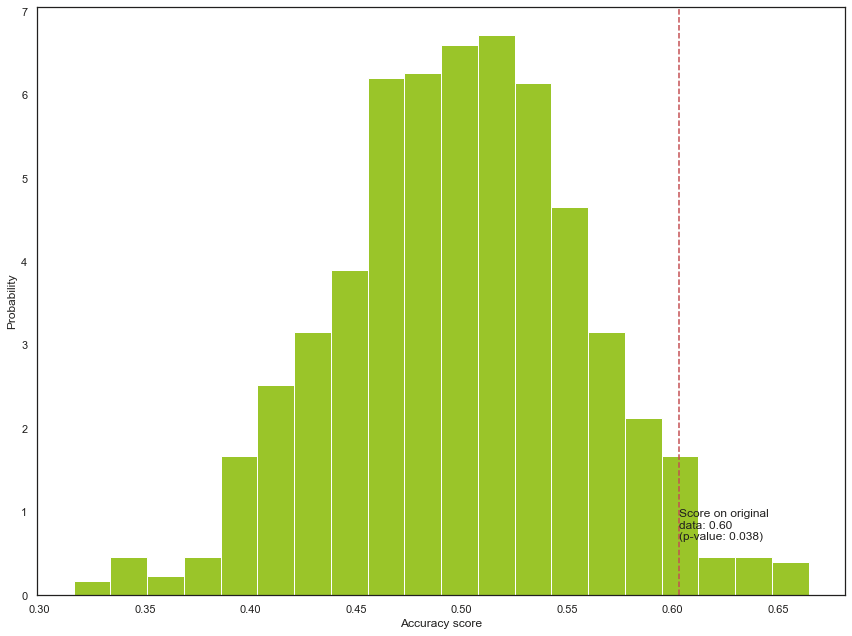

In [9]:
df_forest_mind, feat_import_mind, perm_scores_mind, pvalue_mind = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind.drop('mind2', axis = 1).columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5, 
                                 permutation = True, n_permutations = 1000)

df_forest_mind.to_csv(os.path.join(results_path, 'multivariate_forest_mind_segment.csv'))
feat_import_mind.to_csv(os.path.join(results_path, 'feat_import_multivariate_mind.csv'))



In [10]:
df_perm_mind = pd.DataFrame(perm_scores_mind, columns = ['auc']).assign(Model = 'Shuffled')
df_forest_mind['Model'] = 'Original'
df_perm_mind.to_csv(os.path.join(results_path, 'multivariate_permutation_mind_segment.csv'))

In [11]:
df = pd.concat([df_perm_mind, df_forest_mind])
fig = px.histogram(df_perm_mind, x='auc', color="Model",nbins = 25,  color_discrete_sequence = [pink])

fig.add_vline(x=df_forest_mind.auc.mean(), line_width=3, line_dash="dash", line_color="grey")

fig.add_annotation(x=df_forest_mind.auc.mean() + 0.1, y=50,
            text=f"Score on original labels: <br>Mean AUC: {df_forest_mind.auc.mean():.3f}<br>p = {pvalue_mind:.3f}",
            showarrow=False,
            arrowhead=1,
            align = 'left',
            )


fig.update_layout(
#     title = f'Mean AUC = {df_forest_mind.auc.mean()}',
    autosize=False,
    template = "plotly_white",
    font=dict(
        family="Times new roman",
        size=20,
        color="black"
    ),
    width=800,
    height=800,
    bargap=0.05,
    yaxis = {'title': '',
             'tickfont': {"size": 20},
    },
    xaxis ={'title':'CV AUC',
             'range':[0.25, 0.75],
             'tickfont':{"size": 20}
        }
)
fig.show()

fig.write_image(os.path.join(fig_path, 'multivariate_perm_mind.png'))
fig.write_image(os.path.join(fig_path, 'multivariate_perm_mind.svg'))

In [12]:
fig =px.violin(df_forest_mind, x = 'auc', box = True, points = 'all',template = "plotly_white", color_discrete_sequence = [pink], labels = {'auc': 'AUC'})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
#     title = f'Mean AUC = {df_forest_mind.auc.mean()}',
    autosize=False,
    width=800,
    height=800,
    yaxis = {'title': 'Whole model',
            'showticklabels': True,
            'tickmode': 'linear',},
    xaxis ={
             'range':[0.2, 1]
        }
)
fig.show()

In [13]:
top_10 = feat_import_mind.sort_values(by = 'mean_importance').tail(10)
fig = px.scatter(top_10,x = 'mean_importance', y = 'features', template = "plotly_white",
                  color_discrete_sequence = [pink],

                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']}, 
                 labels = {'value':'Feature importance', 'features': 'Markers'}

                )

fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    width=650,
    height=900,
#     autosize = True, 
    template = 'plotly_white',
        font=dict(
        family="Times new roman",
        size=20,
        color="black"
    ),
    xaxis = dict(
            visible=True,
            # range = [0.37,0.63], 
            tickfont = {"size": 20},
            title = 'Feature Importance'
        ),
    yaxis = dict(
        tickfont = {"size": 20},
        # autorange = False,    
        automargin = True,
        # range = [-1,len(feat_import_mw)],
        dtick = 1
        ),
    showlegend=True, 

)

fig.show()
# pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
fig.write_image(os.path.join(fig_path, 'feat_importance_mind.png'))
fig.write_image(os.path.join(fig_path, 'feat_importance_mind.svg'))

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [14]:
agg_dict = {k:['mean','std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

# df_mw.columns = df_mw.columns.map("_".join)

# df_mw  = (df_mw
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
#             .drop(['participant', 'probe', 'segment'], axis = 1) 
#            )



#### Use latex command for nmaes###
####it slow downs the computer, just for final figures.

df_mw = correct_name_markers(df_mw)

df_mw.columns = df_mw.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_mw  = (df_mw
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment', 'mind$_{}$':'mind'})
#             .query("mind != 'dMW'") #if you want to test against just one of the mw   
            .drop(['participant', 'probe',  'segment'], axis = 1)

           )

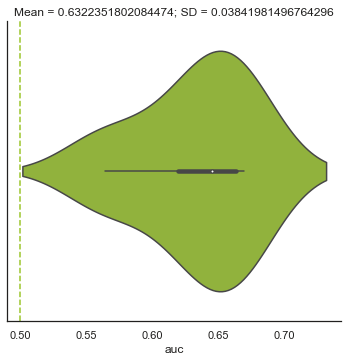

p_value = 0.000999000999000999


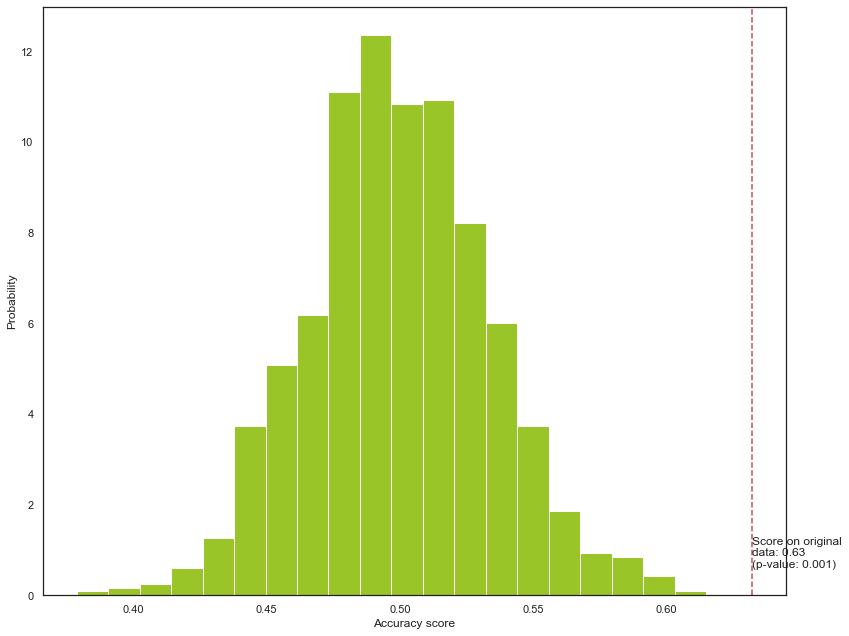

In [ ]:
df_forest_mw, feat_import_mw, perm_scores_mw, pvalue_mw= multivariate_classifier(data = df_mw, label = 'mind', features = df_mw.drop('mind', axis = 1).columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5, 
                                 permutation = True, n_permutations = 1000)

df_forest_mw.to_csv(os.path.join(results_path, 'multivariate_forest_mw_segment.csv'))
feat_import_mw.to_csv(os.path.join(results_path, 'feat_import_multivariate_mw.csv'))

In [16]:
df_perm_mw= pd.DataFrame(perm_scores_mw, columns = ['auc']).assign(Model = 'Shuffled')
df_forest_mw['Model'] = 'Original'


df_perm_mw.to_csv(os.path.join(results_path,'multivariate_permutation_mw_segment.csv'))

In [17]:
df = pd.concat([df_perm_mw, df_forest_mw])
fig = px.histogram(df_perm_mind, x='auc', color="Model",nbins = 25,  color_discrete_sequence = [lblue])

fig.add_vline(x=df_forest_mw.auc.mean(), line_width=3, line_dash="dash", line_color="grey")

fig.add_annotation(x=df_forest_mw.auc.mean() + 0.1, y=50,
            text=f"Score on original labels: <br>Mean AUC: {df_forest_mw.auc.mean():.3f}<br>p = {pvalue_mw:.3f}",
            showarrow=False,
            arrowhead=1,
            align = 'left',
            )


fig.update_layout(
#     title = f'Mean AUC = {df_forest_mind.auc.mean()}',
    autosize=False,
    template = "plotly_white",
    font=dict(
        family="Times new roman",
        size=20,
        color="black"
    ),
    width=800,
    height=800,
    bargap=0.05,
    yaxis = {'title': '',
             'tickfont': {"size": 20},
    },
    xaxis ={'title':'CV AUC',
             'range':[0.25, 0.75],
             'tickfont':{"size": 20}
        }
)
fig.show()

fig.write_image(os.path.join(fig_path, 'multivariate_perm_mw.png'))
fig.write_image(os.path.join(fig_path, 'multivariate_perm_mw.svg'))

In [18]:
fig =px.violin(df_forest_mw, x = 'auc', box = True, points = 'all',template = "plotly_white", color_discrete_sequence = [lblue], labels = {'auc': 'AUC'})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
#     title = f'Mean AUC = {df_forest_mw.auc.mean()}',
    autosize=False,
    width=800,
    height=800,
    yaxis = {'title': 'Whole model',
            'showticklabels': True,
            'tickmode': 'linear',},
    xaxis ={
             'range':[0.2, 1]
        }
)
fig.show()

In [19]:
fig = px.scatter(feat_import_mw.sort_values(by = 'mean_importance').tail(10),x = 'mean_importance', y = 'features', template = "plotly_white",
                  color_discrete_sequence = [lblue],

                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']}, 
                 labels = {'value':'Feature importance', 'features': 'Markers'}

                )

fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    width=650,
    height=900,
#     autosize = True, 
    template = 'plotly_white',
        font=dict(
        family="Times new roman",
        size=20,
        color="black"
    ),
    xaxis = dict(
            visible=True,
            # range = [0.37,0.63], 
            tickfont = {"size": 20},
            title = 'Feature Importance'
        ),
    yaxis = dict(
        tickfont = {"size": 20},
        # autorange = False,    
        automargin = True,
        # range = [-1,len(feat_import_mw)],
        # dtick = 1
        ),
    showlegend=True, 

)

fig.show()
# pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
fig.write_image(os.path.join(fig_path, 'feat_importance_mw.png'))
fig.write_image(os.path.join(fig_path, 'feat_importance_mw.png'))


## Probe Caught vs Self-Caught


In [20]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_probe = (
    df_markers
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

# df_probe.columns = df_probe.columns.map("_".join)

# df_probe  = (df_probe
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
#             .drop(['participant', 'mind', 'segment'], axis = 1) 
#            )

#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_probe = correct_name_markers(df_probe)

df_probe.columns = df_probe.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))

df_probe  = (df_probe
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment'})
           
            .drop(['participant', 'mind', 'segment'], axis = 1) 
           )


rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

probe_rus = rus.fit_resample(df_probe.drop('probe', axis = 1).astype("float32").values, df_probe.probe)

df_probe_rus = pd.DataFrame(probe_rus[0], columns =df_probe.drop('probe', axis = 1).columns ).assign(probe = probe_rus[1])


ros = SMOTE(random_state=42)# fit predictor and target variable

probe_ros = ros.fit_resample(df_probe.drop('probe', axis = 1).astype("float32").values, df_probe.probe)

df_probe_ros = pd.DataFrame(probe_ros[0], columns =df_probe.drop('probe', axis = 1).columns ).assign(probe = probe_ros[1])

In [21]:
data = df_probe
label = 'probe'
features = df_probe.drop('probe', axis = 1).columns
cv_splits = 5
n_permutations = 1000

#pipeline steps init
steps = [("scaler", StandardScaler())]

steps.append(('rus', RandomUnderSampler(random_state=42, replacement=True) ))



y, lbl = pd.factorize(data[label])
X = data[features].astype("float32").values
    
n_estimators = 1000
steps.append(('Forest',ExtraTreesClassifier(
        n_estimators=n_estimators, max_features=1, criterion='entropy',
        max_depth=None, random_state=42, class_weight=None)))

pipe_cv = imb_pipeline(steps)

cv = KFold(cv_splits, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=pipe_cv,
    scoring='roc_auc', cv=cv,  n_jobs = -1)


df_forest_probe_rus = pd.DataFrame(aucs, columns=["auc"])


sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()


# Feature importance

pipe_cv.fit(X, y)
variable_importance = pipe_cv.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

feat_imp_probe_rus = pd.DataFrame(np.array([features,variable_importance]).T, 
                           columns = ['features', 'value']).sort_values('value', ascending = False)

sns.scatterplot(x = feat_import.value, y =feat_import.features)
plt.title(f'AUC = {np.mean(df_auc.auc)}')
plt.show()


score, perm_scores, pvalue = permutation_test_score(
    pipe_cv, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
)


print(f"p_value = {pvalue}")

plt.hist(perm_scores, bins=20, density=True)
plt.axvline(score, ls="--", color="r")
score_label = (
    f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
)
plt.text(score, np.max(perm_scores), score_label, fontsize=12)
plt.xlabel("Accuracy score")
plt.ylabel("Probability")
plt.show()

: 

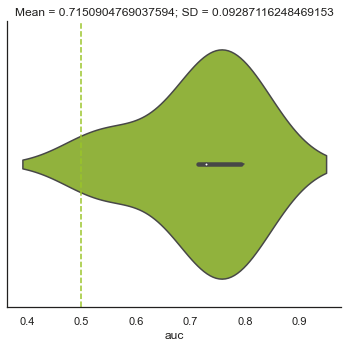

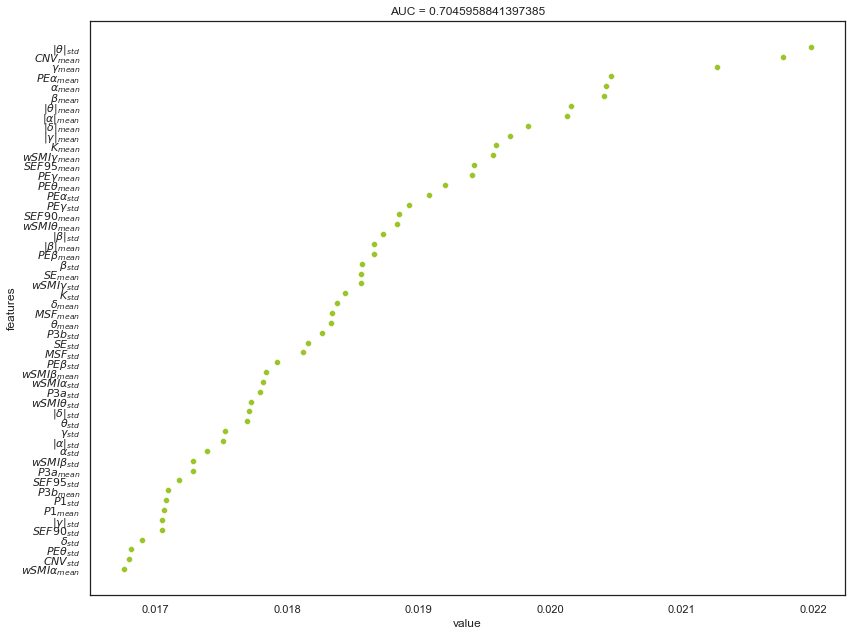

In [ ]:
data = df_probe
label = 'probe'
features = df_probe.drop('probe', axis = 1).columns
cv_splits = 5
n_permutations = 1000

#pipeline steps init
steps = [("scaler", StandardScaler())]

steps.append(('ros', SMOTE(random_state=42)))



y, lbl = pd.factorize(data[label])
X = data[features].astype("float32").values
    
n_estimators = 1000
steps.append(('Forest',ExtraTreesClassifier(
        n_estimators=n_estimators, max_features=1, criterion='entropy',
        max_depth=None, random_state=42, class_weight=None)))

pipe_cv = imb_pipeline(steps)

cv = KFold(cv_splits, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=pipe_cv,
    scoring='roc_auc', cv=cv,  n_jobs = -1)


df_forest_probe_ros = pd.DataFrame(aucs, columns=["auc"])


sns.catplot(x = 'auc', orient = 'h', data = df_forest_probe_ros, kind = 'violin')
plt.title(f'Mean = {np.mean(df_forest_probe_ros.auc)}; SD = {np.std(df_forest_probe_ros.auc)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()


# Feature importance

pipe_cv.fit(X, y)
variable_importance = pipe_cv.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

feat_imp_probe_ros = pd.DataFrame(np.array([features,variable_importance]).T, 
                           columns = ['features', 'value']).sort_values('value', ascending = False)

sns.scatterplot(x = feat_imp_probe_ros.value, y =feat_imp_probe_ros.features)
plt.title(f'AUC = {np.mean(df_auc.auc)}')
plt.show()


# score, perm_scores, pvalue = permutation_test_score(
#     pipe_cv, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
# )


# print(f"p_value = {pvalue}")

# plt.hist(perm_scores, bins=20, density=True)
# plt.axvline(score, ls="--", color="r")
# score_label = (
#     f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
# )
# plt.text(score, np.max(perm_scores), score_label, fontsize=12)
# plt.xlabel("Accuracy score")
# plt.ylabel("Probability")
# plt.show()

In [ ]:
df_forest_probe_ros['balance'] = 'over-sample' 
df_forest_probe_rus['balance'] = 'under-sample' 

df_forest_probe = pd.concat([df_forest_probe_rus, df_forest_probe_ros])

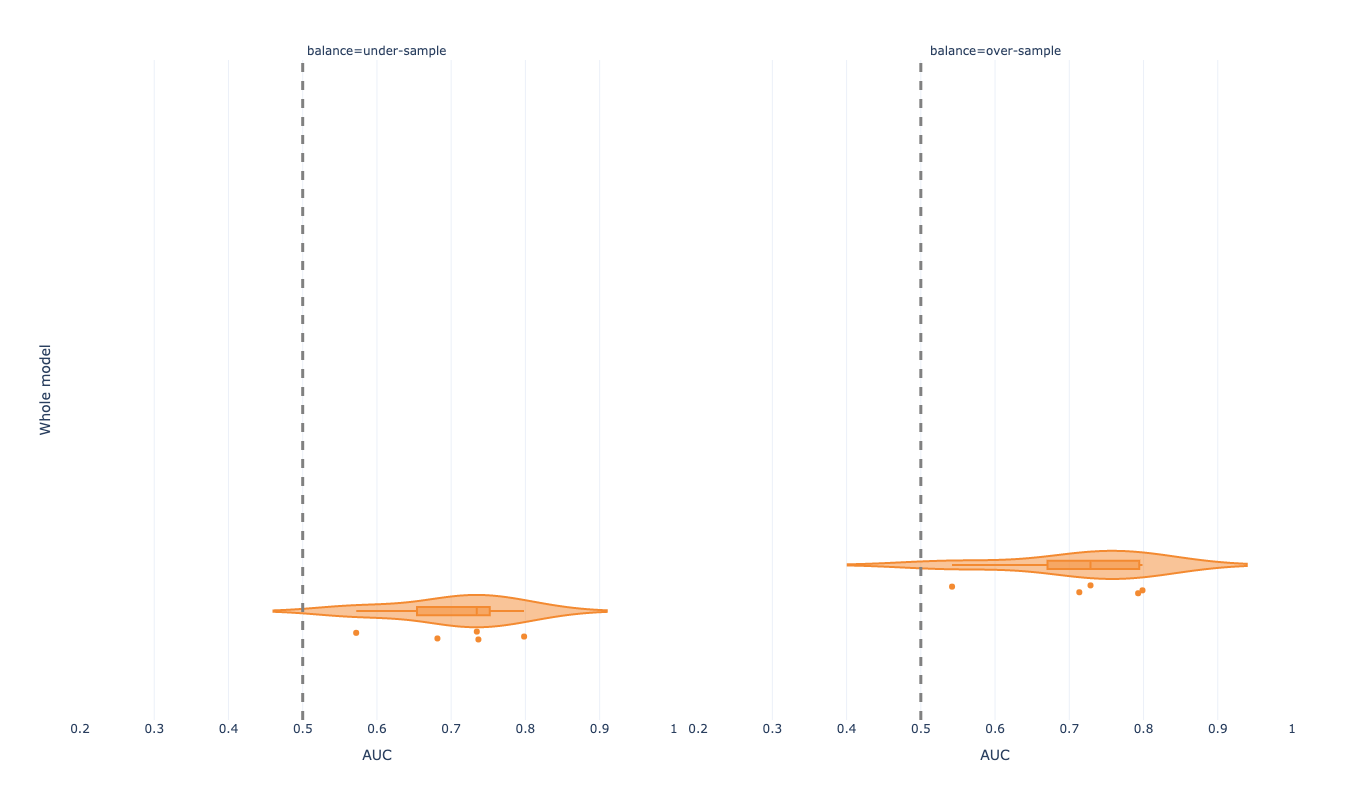

In [ ]:
fig =px.violin(df_forest_probe, x = 'auc', box = True, points = 'all',template = "plotly_white", 
               color_discrete_sequence = [orange, green], labels = {'auc': 'AUC'},
              facet_col = 'balance')
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
#     title = f'Mean AUC = {df_forest_mw.auc.mean()}',
    autosize=True,
    width=800,
    height=800,
    yaxis = {'title': 'Whole model',
            'showticklabels': True,
            'tickmode': 'linear',},
    xaxis ={
             'range':[0.2, 1]
        }
)
fig.show()

In [ ]:
fig = px.scatter(feat_imp_probe_ros.sort_values(by = 'value'),x = 'value', y = 'features', template = "plotly_white",
                  color_discrete_sequence = [orange],

                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']}, 
                 labels = {'value':'Feature importance', 'features': 'Markers'}

                )

fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=1000,
#     xaxis= {'range': (0.34, 0.66)},
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }

)

fig.show()

# Multivariate only wih significant markers

In [ ]:
svm_mind = pd.read_csv('Data/univariate_roc_mind_segment.csv')
aucs_mind = svm_mind.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'})

svm_mw = pd.read_csv('Data/univariate_roc_mw_segment.csv')
aucs_mw = svm_mw.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'})


significant_mind = aucs_mind.query("significant != 'p > 0.05'").markers.to_list()
# significant_mw = aucs_mw.query("significant != 'p > 0.05'").markers.to_list()
significant_mw = aucs_mw.query("significant == 'p < 0.05 FDR corrected'").markers.to_list()


significant_markers = significant_mind + significant_mw

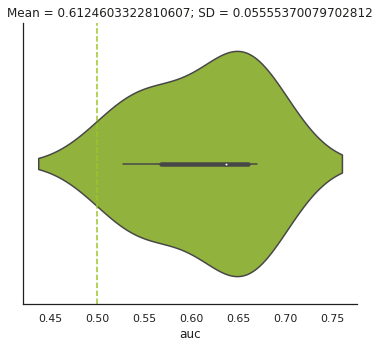

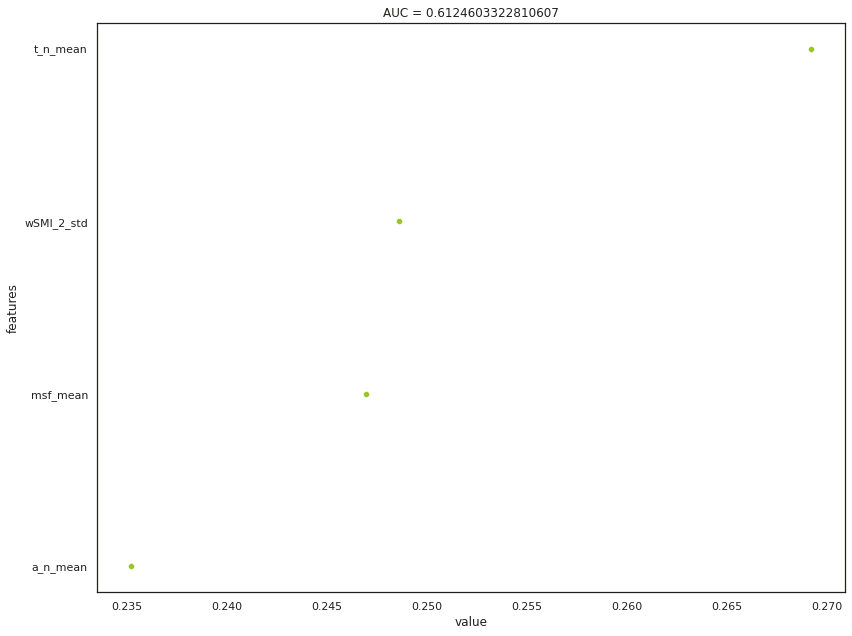

In [ ]:
df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[significant_mind].columns, 
                                 model = 'forest', pca =False, n_components = 10,
                                 cv_splits= 5,
                                 permutation = False, n_permutations = 1000)

df_auc_mind_significants.to_csv('Data/multivariate_mind_segment_significants.csv')

# Multivariate only wih 2 most important markers

In [ ]:
svm_mind = pd.read_csv('Data/univariate_roc_mind_segment.csv')
aucs_mind = svm_mind.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'})

svm_mw = pd.read_csv('Data/univariate_roc_mw_segment.csv')
aucs_mw = svm_mw.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'})


significant_mind = aucs_mind.query("significant != 'p > 0.05'").markers.to_list()
# significant_mw = aucs_mw.query("significant != 'p > 0.05'").markers.to_list()
significant_mw = aucs_mw.query("significant == 'p < 0.05 FDR corrected'").markers.to_list()


significant_markers = significant_mind + significant_mw

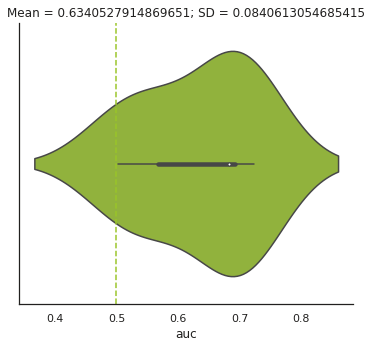

In [ ]:
df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[['t_n_std', 't_n_mean']].columns, 
                                 model = 'SVM', pca =False, n_components = 10,
                                 cv_splits= 5, grid_search  =False,
                                 permutation = False, n_permutations = 1000)

df_auc_mind_significants.to_csv('Data/multivariate_mind_segment_significants.csv')